In [ ]:
# Install any missing packages (Colab usually has these)
!pip install --quiet opencv-python-headless==4.7.0.72 numpy matplotlib requests


In [1]:
# Imports and helpers
import os
import json
from pathlib import Path
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D    # noqa: F401 (used by matplotlib 3D)
plt.rcParams['figure.dpi'] = 100

RESULTS_DIR = '/content/results_shape_from_shading'
os.makedirs(RESULTS_DIR, exist_ok=True)

def show_gray(img, title=''):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.title(title); plt.axis('off'); plt.show()

def show_color(img_bgr, title=''):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb); plt.title(title); plt.axis('off'); plt.show()


Saved original to: /content/results_shape_from_shading/original_shaded.png


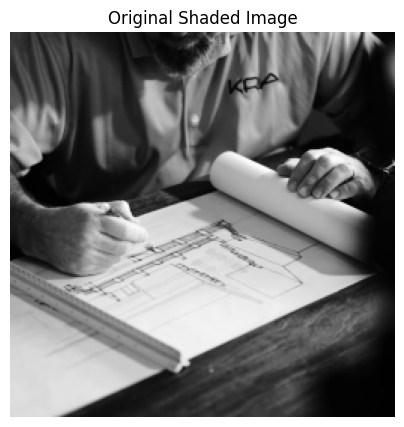

In [2]:
# Download a reliable grayscale/shaded image (Unsplash)
url = "https://images.unsplash.com/photo-1503387762-592deb58ef4e?auto=format&w=800&h=800&fit=crop"
headers = {"User-Agent":"Mozilla/5.0"}

resp = requests.get(url, headers=headers, timeout=15)
resp.raise_for_status()
img_arr = np.asarray(bytearray(resp.content), dtype=np.uint8)
img_gray = cv2.imdecode(img_arr, cv2.IMREAD_GRAYSCALE)

# Safety check
if img_gray is None:
    raise RuntimeError("Image download failed. Try re-running or change URL.")

# Resize to a manageable size (square)
img_gray = cv2.resize(img_gray, (256, 256), interpolation=cv2.INTER_AREA)

# Save original
orig_path = os.path.join(RESULTS_DIR, 'original_shaded.png')
cv2.imwrite(orig_path, img_gray)
print("Saved original to:", orig_path)

# Display
show_gray(img_gray, "Original Shaded Image")


Saved height map to: /content/results_shape_from_shading/height_map.png


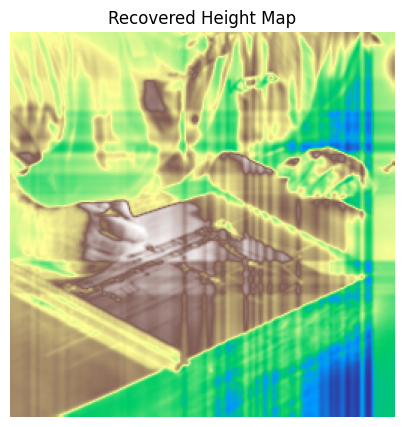

In [3]:
# Normalize intensities to [0,1]
I = img_gray.astype('float32') / 255.0

# Compute image gradients (Sobel)
gx = cv2.Sobel(I, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)  # ∂I/∂x
gy = cv2.Sobel(I, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)  # ∂I/∂y

# Optionally smooth gradients to reduce noise
# from scipy.ndimage import gaussian_filter
# gx = gaussian_filter(gx, sigma=1)
# gy = gaussian_filter(gy, sigma=1)

# Interpret gx, gy as p and q (slopes). Integrate to get an approximate height map Z.
# Simple integration by cumulative sum (fast, approximate)
Zx = np.cumsum(gx, axis=1)      # integrate along x
Zy = np.cumsum(gy, axis=0)      # integrate along y
Z = (Zx + Zy) / 2.0

# Normalize Z to [0,1] for visualization
Z = Z - np.min(Z)
if np.max(Z) > 0:
    Z = Z / np.max(Z)

# Save heightmap as image
heightmap_path = os.path.join(RESULTS_DIR, 'height_map.png')
# convert to 8-bit colormap for saving
heightmap_vis = (255 * Z).astype(np.uint8)
cv2.imwrite(heightmap_path, heightmap_vis)
print("Saved height map to:", heightmap_path)

# Display height map
plt.figure(figsize=(5,5))
plt.imshow(Z, cmap='terrain'); plt.title("Recovered Height Map"); plt.axis('off'); plt.show()


Saved 3D surface visualization to: /content/results_shape_from_shading/surface_3d.png


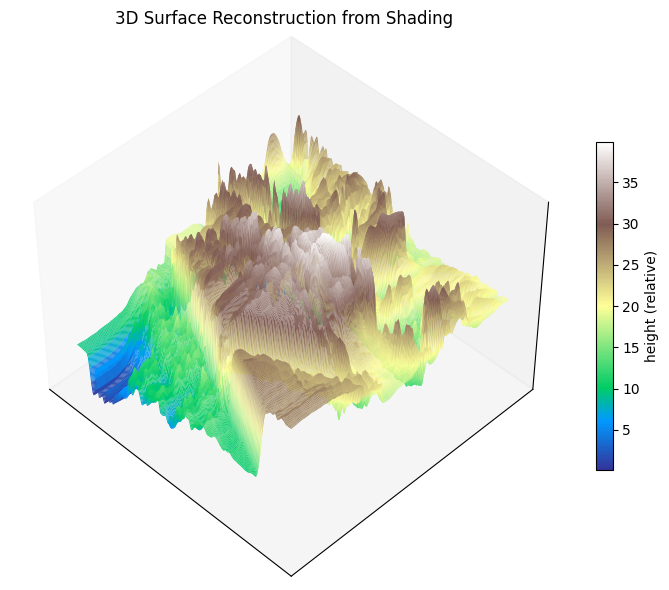

In [4]:
# Create a 3D surface plot of Z
X, Y = np.meshgrid(np.arange(Z.shape[1]), np.arange(Z.shape[0]))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# scale factor to exaggerate height for visualization
scale = 40
surf = ax.plot_surface(X, Y, Z*scale, rstride=1, cstride=1, cmap='terrain', linewidth=0, antialiased=True)
ax.set_title("3D Surface Reconstruction from Shading")
ax.view_init(45, 135)
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
fig.colorbar(surf, shrink=0.6, label='height (relative)')
plt.tight_layout()

# Save the 3D figure to a PNG
three_d_path = os.path.join(RESULTS_DIR, 'surface_3d.png')
fig.savefig(three_d_path, dpi=150)
print("Saved 3D surface visualization to:", three_d_path)
plt.show()


In [5]:
# Make a small JSON summary
summary = {
    'original_image': orig_path,
    'height_map': heightmap_path,
    'surface_3d': three_d_path,
    'notes': {
        'method': 'Sobel gradients interpreted as slopes; integrated via cumulative sum to produce relative height map',
        'assumptions': 'Lambertian reflectance, single light source, uniform illumination',
        'limitations': 'Relative depth only; sensitive to lighting and noise; not metric scale'
    }
}
summary_path = os.path.join(RESULTS_DIR, 'summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print("Saved summary JSON to:", summary_path)

# Zip results for easy download
!zip -r /content/shape_from_shading_results.zip {RESULTS_DIR} > /dev/null
from google.colab import files
files.download('/content/shape_from_shading_results.zip')


Saved summary JSON to: /content/results_shape_from_shading/summary.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>